In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import methods.Colors_Descriptors as CD
from typing import Tuple, List, Union, Type

uint8


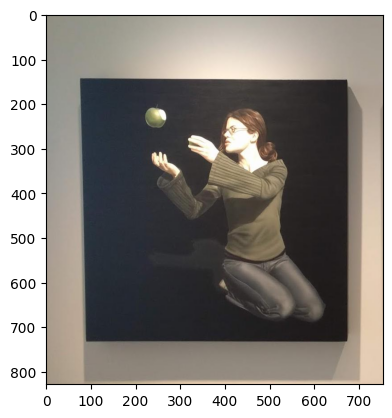

In [7]:
test_img = np.array(Image.open('../data/qsd2_w1/00001.jpg'))
print(test_img.dtype)
plt.imshow(test_img)
plt.show()

In [42]:
arr = np.array([[1,2], [3,4], [-1, 2]])
sorted(arr, key=lambda x: x[0])

[array([-1,  2]), array([1, 2]), array([3, 4])]

In [8]:
Point = Tuple[int, int]

class Quad:
    def __init__(self, points: List[Point]) -> None:
        if len(points) != 4:
            raise ValueError('Need exactly 4 points.')
        self.V = np.array(points)
        center = np.sum(self.V, axis=0) / 4
        self.V = np.array(sorted(self.V, key=lambda x: np.arctan2(x[1] - center[1], x[0] - center[0])))
    
    def contains(self, point: Point):
        point = np.array(point)

        crossprods = []
        for i in range(3):
            crossprods.append(np.cross(self.V[i+1] - self.V[i], point - self.V[i]))
        crossprods.append(np.cross(self.V[0] - self.V[3], point - self.V[3]))

        signs = list(map(lambda x: x >= 0, crossprods))
        if not any(signs):
            print(f'Warning: are vertices ordered clockwise? {self.V=}')
        return all(signs)
    
    def get_area(self):
        return 0.5 * ((self.V[0,0] - self.V[2,0])*(self.V[1,1] - self.V[3,1]) - (self.V[1,0] - self.V[3,0])*(self.V[0,1] - self.V[2,1]))

    def __getitem__(self, i):
        return self.V[i]

In [9]:
from skimage.draw import polygon


def get_lines_intersection(l1p1, l1p2, l2p1, l2p2):
    x1 = l1p1[0]; y1 = l1p1[1]
    x2 = l1p2[0]; y2 = l1p2[1]

    x3 = l2p1[0]; y3 = l2p1[1]
    x4 = l2p2[0]; y4 = l2p2[1]

    den = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)
    rx = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4))/den
    ry = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4))/den
    return np.array([rx, ry])


def get_histogram_descriptor_quad(img: np.ndarray, quad: Quad, **kwargs):
    rr, cc = polygon(quad.V[:,0], quad.V[:,1], img.shape)
    hist, _ = np.histogram(img[rr, cc], **kwargs)
    feature = hist/np.sum(hist)
    return feature


def get_multi_tile_histogram_descriptor_quad(img: np.ndarray, quad: Quad, tiles:int=2, **kwargs):
    """
    Compute a multi-tile histogram descriptor for the given image.

    Parameters:
        img (np.array): Input image.
        tiles (int): Number of tiles to divide the image into. Default is 10.
        channel (int): Channel to compute the histogram for. Default is 1.
        **kwargs: Additional keyword arguments for np.histogram.

    Returns:
        list: List of histograms for each tile.
    """


    # Vertical cut points
    l_edge = quad[1] - quad[0]
    step_i_l =  l_edge / tiles
    r_edge = quad[2] - quad[3]
    step_i_r = r_edge / tiles

    # Horizontal cut points
    t_edge = quad[3] - quad[0]
    step_j_t = t_edge / tiles
    b_edge = quad[2] - quad[1]
    step_j_b = b_edge / tiles

    grid = np.zeros((tiles + 1, tiles + 1, 2), dtype=int)
    grid[0, 0] = quad[0]
    grid[tiles, 0] = quad[1]
    grid[tiles, tiles] = quad[2]
    grid[0, tiles] = quad[3]
    for count in range(1, tiles):
        grid[count, 0] =  np.round(grid[0, 0] + step_i_l * count)
        grid[count, tiles] = np.round(grid[0, tiles] + step_i_r * count)
        grid[0, count] =  np.round(grid[0, 0] + step_j_t * count)
        grid[tiles, count] = np.round(grid[tiles, 0] + step_j_b * count)
    
    print(grid)
    feature = np.array([])
    for i in range(1, tiles):
        for j in range(1, tiles):
            print(i,j)
            grid[i, j] = get_lines_intersection(grid[i, 0], grid[i, tiles], grid[0, j], grid[tiles, j])

            new_quad = Quad([grid[i-1, j-1], grid[i, j-1], grid[i, j], grid[i-1, j]])
            feature = np.concatenate((feature, get_histogram_descriptor_quad(img, new_quad)), axis=-1)
    
    img_copy = img.copy()
    for i in range(tiles+1):
        for j in range(tiles+1):
            img_copy[grid[i,j][0]:grid[i,j][0]+10, grid[i,j][1]:grid[i,j][1]+10, 0] = 255
            img_copy[grid[i,j][0]:grid[i,j][0]+10, grid[i,j][1]:grid[i,j][1]+10, 1] = 0
            img_copy[grid[i,j][0]:grid[i,j][0]+10, grid[i,j][1]:grid[i,j][1]+10, 2] = 0
    plt.imshow(img_copy)
    plt.show()

    return feature

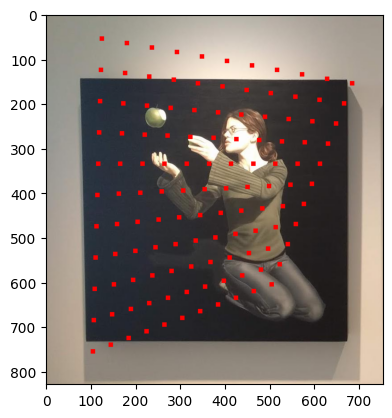

array([8.65595646e-02, 1.07541041e-01, 7.26889650e-02, 9.63918883e-02,
       1.26064437e-01, 2.03493986e-01, 1.87779826e-01, 7.77807041e-02,
       2.77411992e-02, 1.39583882e-02, 5.21880946e-02, 1.03560750e-01,
       9.86681163e-02, 1.80574431e-01, 1.65171695e-01, 1.61003896e-01,
       1.14795687e-01, 6.64129745e-02, 3.24363505e-02, 2.51880040e-02,
       5.29351568e-02, 1.04660899e-01, 1.29128291e-01, 1.53595683e-01,
       1.58433343e-01, 1.60852172e-01, 1.06335473e-01, 6.41920179e-02,
       4.46553168e-02, 2.52116476e-02, 1.57342657e-02, 4.95337995e-03,
       0.00000000e+00, 1.55400155e-03, 5.43900544e-03, 2.91375291e-03,
       2.39898990e-02, 3.46445221e-01, 3.95881896e-01, 2.03088578e-01,
       1.04941977e-01, 2.85114046e-02, 1.90076030e-03, 0.00000000e+00,
       3.00120048e-04, 9.90396158e-03, 6.00240096e-03, 1.86674670e-01,
       3.62444978e-01, 2.99319728e-01, 1.76772437e-01, 7.99036548e-02,
       4.71253534e-03, 5.02670437e-03, 4.60781234e-03, 1.98973715e-03,
      

In [47]:
get_multi_tile_histogram_descriptor_quad(test_img, Quad([ [600, 500], [150, 680], [50, 120], [750, 100]]))

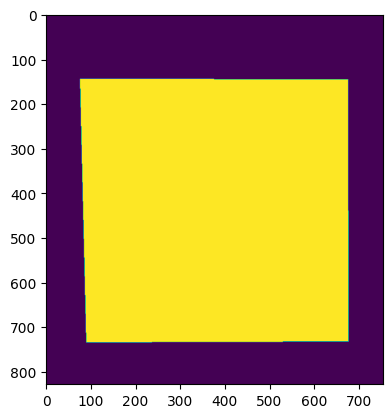

In [57]:
test_mask = np.array(Image.open('../data/qsd2_w1/00001.png'))
plt.imshow(test_mask)
plt.show()

In [58]:
from scipy.spatial import ConvexHull
import cv2
conts, lol = cv2.findContours(test_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
hull = ConvexHull(np.flip(conts[0][: , 0], axis=-1))

In [64]:
np.flip(conts[0][: , 0], axis=-1)

array([[145,  76],
       [166,  76],
       [167,  77],
       [208,  77],
       [209,  78],
       [250,  78],
       [251,  79],
       [292,  79],
       [293,  80],
       [334,  80],
       [335,  81],
       [376,  81],
       [377,  82],
       [418,  82],
       [419,  83],
       [460,  83],
       [461,  84],
       [502,  84],
       [503,  85],
       [544,  85],
       [545,  86],
       [586,  86],
       [587,  87],
       [628,  87],
       [629,  88],
       [670,  88],
       [671,  89],
       [712,  89],
       [713,  90],
       [734,  90],
       [734, 236],
       [733, 237],
       [733, 529],
       [732, 530],
       [732, 676],
       [440, 676],
       [439, 675],
       [146, 675],
       [146, 376],
       [145, 375]], dtype=int32)

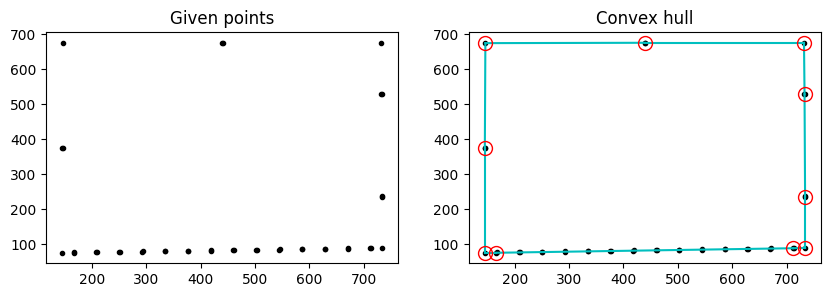

In [63]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))

points = np.flip(conts[0][: , 0], axis=-1)
for ax in (ax1, ax2):
    ax.plot(points[:, 0], points[:, 1], '.', color='k')
    if ax == ax1:
        ax.set_title('Given points')
    else:
        ax.set_title('Convex hull')
        for simplex in hull.simplices:
            ax.plot(points[simplex, 0], points[simplex, 1], 'c')
        ax.plot(points[hull.vertices, 0], points[hull.vertices, 1], 'o', mec='r', color='none', lw=1, markersize=10)
plt.show()

In [67]:
points[hull.vertices]

array([[145,  76],
       [166,  76],
       [712,  89],
       [734,  90],
       [734, 236],
       [733, 529],
       [732, 676],
       [440, 676],
       [146, 675],
       [145, 375]], dtype=int32)

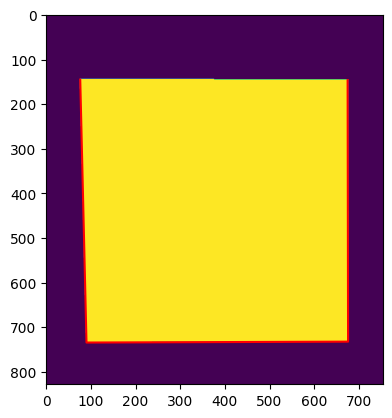

In [70]:
import itertools

max_area = 0
best_quad = None
for vertex_set in itertools.combinations(points[hull.vertices], 4):
    temp_quad = Quad(vertex_set)
    area = temp_quad.get_area()
    if area > max_area:
        max_area = area
        best_quad = temp_quad
plt.imshow(test_mask)
plt.plot(best_quad.V[:,1], best_quad.V[:,0], color='red')

In [54]:
best_quad.V

array([[ 76, 145],
       [675, 146],
       [676, 732],
       [ 90, 734]], dtype=int32)

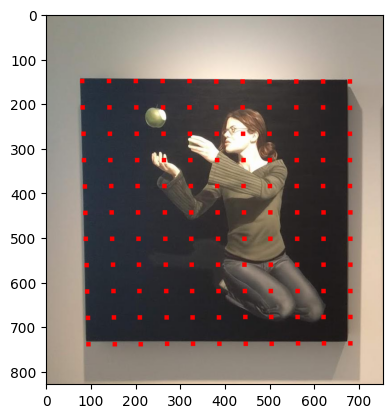

array([2.14973163e-01, 2.65037942e-01, 2.13029798e-01, 2.89746437e-01,
       8.69887100e-03, 2.68369424e-03, 1.29557653e-03, 1.66574125e-03,
       1.94336480e-03, 9.25411808e-04, 1.38811771e-03, 7.46807329e-02,
       1.68610031e-01, 1.00407181e-01, 2.27373681e-01, 9.66129928e-02,
       3.05385897e-02, 1.65556172e-01, 1.31686100e-01, 3.14640015e-03,
       3.49805664e-02, 3.32315380e-01, 3.25097168e-01, 2.80399778e-01,
       1.67499537e-02, 2.96131779e-03, 4.07181196e-03, 2.22098834e-03,
       9.25411808e-04, 2.77623542e-04, 2.86124225e-01, 6.82217902e-01,
       1.44404332e-02, 5.55401277e-04, 2.77700639e-03, 2.77700639e-03,
       1.85133759e-03, 3.23984078e-03, 4.07294270e-03, 1.94390447e-03,
       5.55833333e-01, 4.10555556e-01, 2.54629630e-02, 6.38888889e-03,
       1.48148148e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.25925926e-05, 1.85185185e-04, 1.78060264e-01, 7.28907721e-01,
       7.58003766e-02, 4.89642185e-03, 3.29566855e-03, 2.25988701e-03,
      

In [71]:
get_multi_tile_histogram_descriptor_quad(test_img, best_quad)

In [ ]:
def get_quad_from_mask(mask):
    conts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    hull = ConvexHull(np.flip(conts[0][: , 0], axis=-1))

    points = np.flip(conts[0][: , 0], axis=-1)
    max_area = 0
    best_quad = None
    for vertex_set in itertools.combinations(points[hull.vertices], 4):
        temp_quad = Quad(vertex_set)
        area = temp_quad.get_area()
        if area > max_area:
            max_area = area
            best_quad = temp_quad
    return best_quad

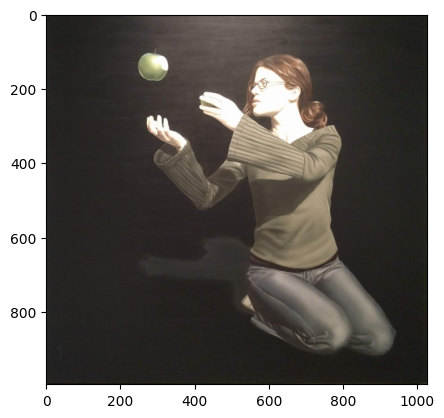

In [10]:
test_img = np.array(Image.open('../data/BBDD/bbdd_00219.jpg'))
plt.imshow(test_img)
plt.show()

[[[   0    0]
  [   0  513]
  [   0 1026]]

 [[ 498    0]
  [   0    0]
  [ 498 1026]]

 [[ 995    0]
  [ 995  513]
  [ 995 1026]]]
1 1


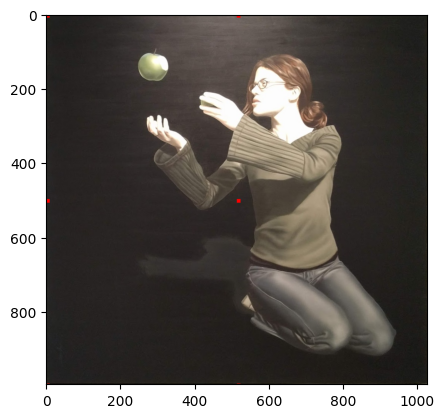

array([0.41101399, 0.26075107, 0.18395026, 0.06690424, 0.01576304,
       0.01003953, 0.00731424, 0.00516337, 0.00478909, 0.03431116])

In [13]:
get_multi_tile_histogram_descriptor_quad(test_img, Quad([[0, 0], [test_img.shape[0]-1, 0], [test_img.shape[0]-1, test_img.shape[1]-1], [0, test_img.shape[1]-1]]))

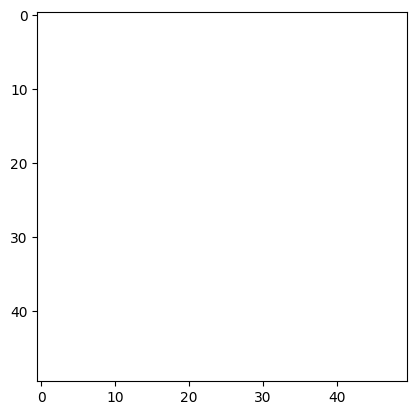

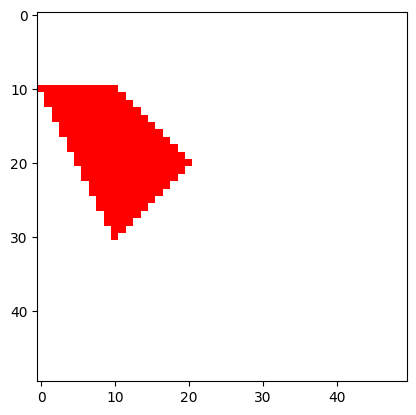

In [96]:
myquad = Quad([[10, 10], [30, 10], [20, 20], [10, 0]])
test_arr = np.full((50, 50, 3), 255, dtype=np.uint8)
plt.imshow(test_arr)
plt.show()
rr, cc = polygon(myquad.V[:,0], myquad.V[:,1], test_arr.shape)
test_arr[rr, cc, 1:3] = 0
plt.imshow(test_arr)
plt.show()

In [111]:
from utils import utils

In [122]:
utils.convert2lab(utils.image2tensor(test_img))[:,:,[1,2]].max()

5055.151

In [10]:
from preprocessing import pipelines
from methods import Colors_Descriptors as CD

pipelines.generate_pyramidal_histogram_descriptor_masked([test_img], [None], steps=3)

1it [00:00,  3.32it/s]


{0: array([4.62337126e-01, 4.67198989e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.38019229e-03, 1.99519662e-01,
        6.20306761e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.19031838e-02, 1.54530852e-01, 6.39411118e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.17043425e-02, 2.91867782e-02, 3.89884828e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 9.04532801e-04, 7.50528294e-03,
        4.07819530e-03, 1.55953931e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.60443065e-03, 7.37272210e-03, 1.664